# Importações

In [ ]:
from PIL import Image
from IPython.display import Video
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as show
import numpy as np
import urllib.request
import math
import dlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

urllib.request.urlretrieve("https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat", './shape_predictor_68_face_landmarks.dat')

('./shape_predictor_68_face_landmarks.dat',
 <http.client.HTTPMessage at 0x7ae0ed9d2990>)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
urllib.request.urlretrieve("https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat", './shape_predictor_68_face_landmarks.dat')
frontalface_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Funções

In [ ]:
#função para extrair os pontos de referencia em uma imagem
def get_landmarks(image_source):

    if image_source.startswith('http'): #caso a imagem seja da internet
        url_response = urllib.request.urlopen(image_source)
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    else:
        image = cv2.imread(image_source)

    if image is None:
        raise ValueError("Imagem não pôde ser carregada. Verifique a URL ou o caminho do arquivo.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #transforma em cinza
    faces = frontalface_detector(gray, 1) #extrai as faces da imagem

    if len(faces) == 0:
        raise ValueError("Nenhum rosto detectado na imagem.")

    landmarks = [(p.x, p.y) for p in landmark_predictor(gray, faces[0]).parts()] #detecta os landmarks
    return image, landmarks #retorna imagem e landmarks

In [ ]:
#função para printar imagem junto com os landmarks
def image_landmarks(image, landmarks, title='Imagem com Landmarks'):

    h, w = image.shape[:2]
    base_radius = max(1, min(h, w) // 200)
    thickness = -1

    image_copy = image.copy()
    for (x, y) in landmarks:
        cv2.circle(image_copy, (x, y), base_radius, (0, 0, 255), thickness)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
#função para ler a imagem, extrair os landmarks e alinhar o rosto
def ler_imagem_e_landmarks(caminho):
    img, lm = get_landmarks(caminho)
    rosto, lm_alinhadas = alinhar_e_cortar_rosto(img, lm)
    return rosto, lm_alinhadas

In [ ]:
#função que realiza a transformação afim (warp) de um triângulo de uma imagem para outro triângulo em uma nova posição
def aplicar_warp_triangle(img, tri1, tri2):
    tri1 = np.array(tri1, dtype=np.float32)
    tri2 = np.array(tri2, dtype=np.float32)

    r1 = cv2.boundingRect(tri1) #retangulos delimitadores dos triangulos
    r2 = cv2.boundingRect(tri2)

    tri1_offset = [(pt[0] - r1[0], pt[1] - r1[1]) for pt in tri1] #offset dos pontos do triângulo em relação aos retângulos
    tri2_offset = [(pt[0] - r2[0], pt[1] - r2[1]) for pt in tri2]

    img1_rect = img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]] #recorta a região do triângulo original da imagem

    M = cv2.getAffineTransform(np.float32(tri1_offset), np.float32(tri2_offset)) #calcula a matriz de transformação afim

    warped = cv2.warpAffine(img1_rect, M, (r2[2], r2[3]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2_offset), (1.0, 1.0, 1.0), 16, 0)

    return warped, mask, r2

In [ ]:
#função para alinhar e cortar rosto antes de detectar os landmarks e aplicar o face morphing
def alinhar_e_cortar_rosto(image, landmarks, tamanho_crop=(750,750), margem=230):

    h, w = image.shape[:2]

    olho_esq = np.mean(landmarks[36:42], axis=0) #detecta o olho esquerdo
    olho_dir = np.mean(landmarks[42:48], axis=0) #detecta o olho direito

    dx = olho_dir[0] - olho_esq[0]
    dy = olho_dir[1] - olho_esq[1]
    angulo = np.degrees(np.arctan2(dy, dx))

    #calcula o centro entre os olhos
    cx, cy = (olho_esq[0] + olho_dir[0]) / 2, (olho_esq[1] + olho_dir[1]) / 2

    #matriz para rotacionar a imagem e alinhar os olhos horizontalmente
    M = cv2.getRotationMatrix2D((cx, cy), angulo, 1.0)
    img_rotacionada = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    landmarks_rotacionadas = []
    for (x, y) in landmarks:
        vetor = np.array([x, y, 1])
        x_rot, y_rot = M.dot(vetor)
        landmarks_rotacionadas.append((int(x_rot), int(y_rot))) #rotaciona os landmarks e adicionar na lista

    xs = [p[0] for p in landmarks_rotacionadas]
    ys = [p[1] for p in landmarks_rotacionadas]

    min_x = max(min(xs) - margem, 0)
    max_x = min(max(xs) + margem, w)
    min_y = max(min(ys) - margem, 0)
    max_y = min(max(ys) + margem, h)

    rosto_crop = img_rotacionada[int(min_y):int(max_y), int(min_x):int(max_x)] #faz um crop do rosto
    landmarks_crop = [(x - min_x, y - min_y) for (x, y) in landmarks_rotacionadas]
    rosto_final = cv2.resize(rosto_crop, tamanho_crop)

    escala_x = tamanho_crop[0] / (max_x - min_x)
    escala_y = tamanho_crop[1] / (max_y - min_y)
    landmarks_final = [(int(x * escala_x), int(y * escala_y)) for (x, y) in landmarks_crop]

    return rosto_final, landmarks_final #retorna o rosto cortado e os landmarks da imagem (sem isso nao funciona)

In [ ]:
def calcular_pontos_intermediarios(lm1, lm2, alpha):
    lm1 = np.array(lm1, dtype=np.float32)
    lm2 = np.array(lm2, dtype=np.float32)
    return (1 - alpha) * lm1 + alpha * lm2

In [ ]:
#função para trasnplantar a face inteira de uma imagem em outra (o resultado não costuma ficar tão bom)
def morphing_faces(img1, img2, lm1, lm2, alpha):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    pontos_inter = calcular_pontos_intermediarios(lm1, lm2, alpha)
    tri = Delaunay(pontos_inter)
    img_morph = np.zeros_like(img1, dtype=img1.dtype)

    for t in tri.simplices:
        tri1 = [lm1[t[0]], lm1[t[1]], lm1[t[2]]]
        tri2 = [lm2[t[0]], lm2[t[1]], lm2[t[2]]]
        tri_inter = [pontos_inter[t[0]], pontos_inter[t[1]], pontos_inter[t[2]]]

        warped1, mask1, r = aplicar_warp_triangle(img1, tri1, tri_inter)
        warped2, _, _ = aplicar_warp_triangle(img2, tri2, tri_inter)

        img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask1) + \
            (warped1 * (1 - alpha) + warped2 * alpha) * mask1

    return np.clip(img_morph, 0, 255).astype(np.uint8)

In [ ]:
#função para linhar o rosto frontalmente
def alinhar_para_frontal(img_origem, lm_origem, lm_destino, fundo_destino):
    pontos_destino = np.array(lm_destino, dtype=np.float32)
    tri = Delaunay(pontos_destino)

    img_resultado = fundo_destino.astype(np.float32).copy()

    for t in tri.simplices:
        tri_src = [lm_origem[t[0]], lm_origem[t[1]], lm_origem[t[2]]]
        tri_dst = [lm_destino[t[0]], lm_destino[t[1]], lm_destino[t[2]]]

        warped, mask, r = aplicar_warp_triangle(img_origem, tri_src, tri_dst)

        img_resultado[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = \
            img_resultado[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + warped * mask

    return np.clip(img_resultado, 0, 255).astype(np.uint8)

# Resultados

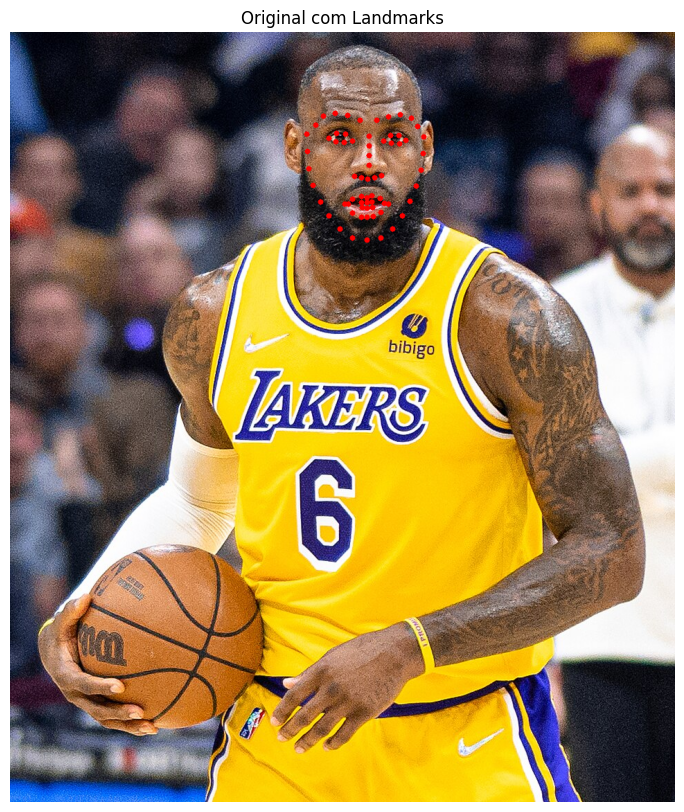

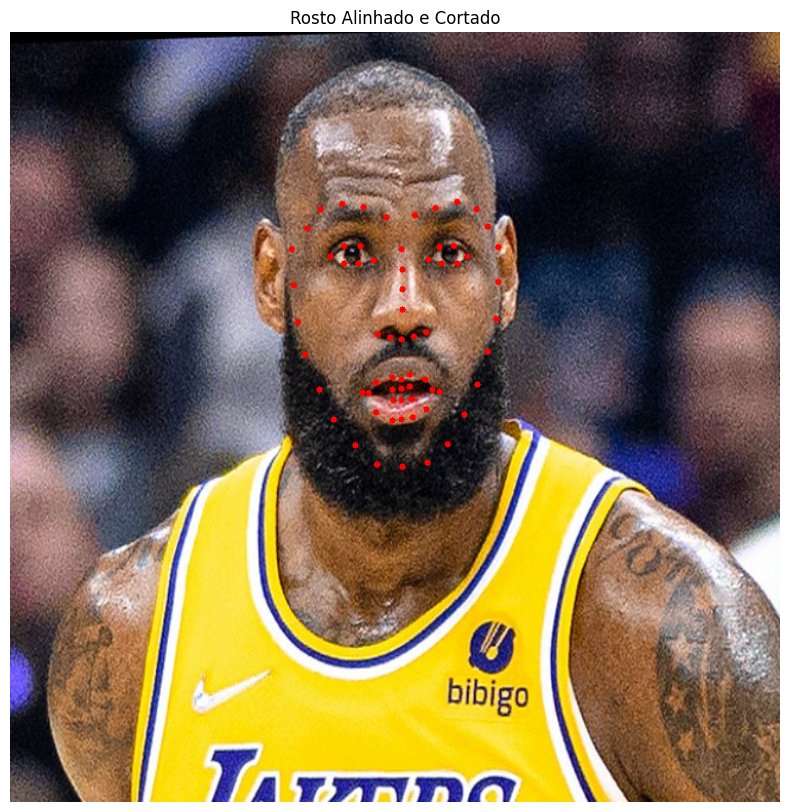

In [ ]:
#testando com uma imagem base
caminho_ou_url = "/content/drive/Shareddrives/Drive de PDI/projeto/Base/lebron_frontal.jpg"
image, landmarks = get_landmarks(caminho_ou_url)
image_landmarks(image, landmarks, title='Original com Landmarks')

rosto_alinhado, landmarks_alinhadas = alinhar_e_cortar_rosto(image, landmarks)
image_landmarks(rosto_alinhado, landmarks_alinhadas, title='Rosto Alinhado e Cortado')

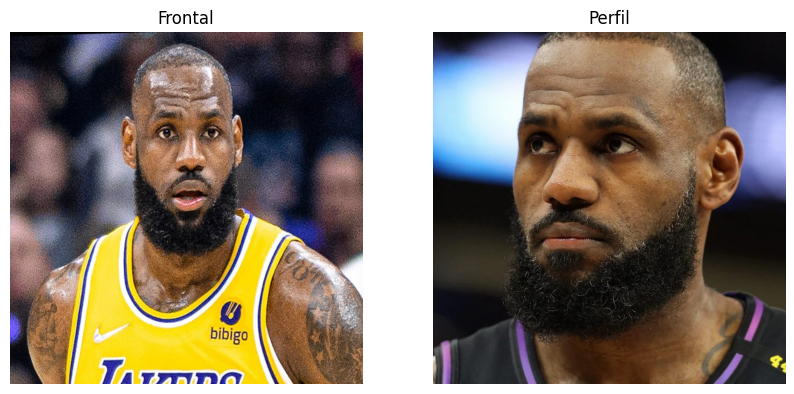

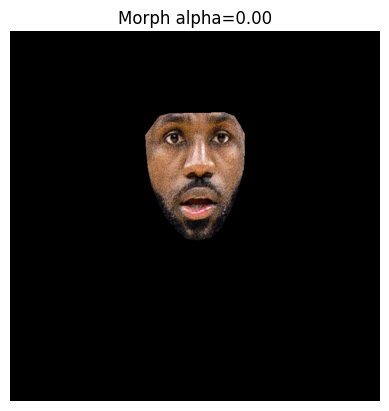

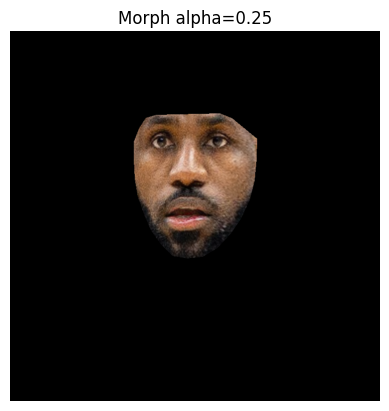

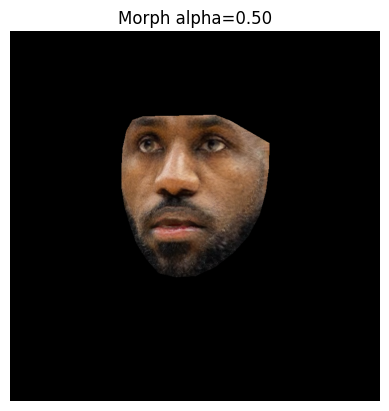

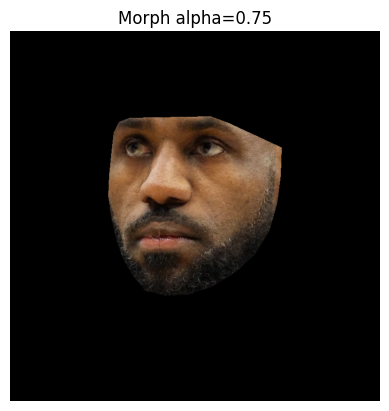

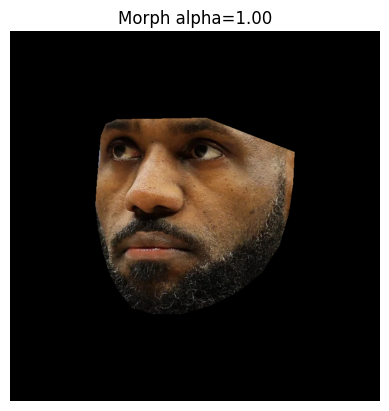

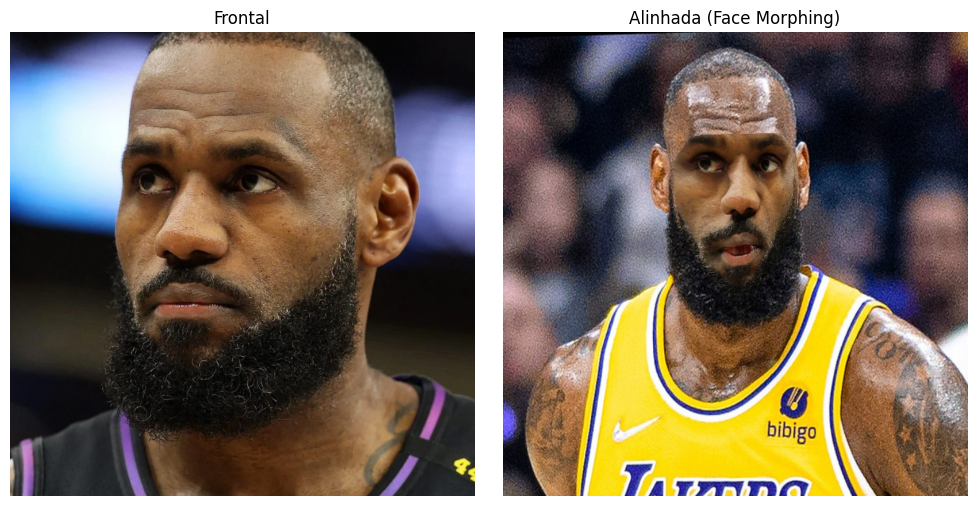

True

In [ ]:
#testando o alinhamento com uma imagem frontal e outra de perfil
caminho1 = "/content/drive/Shareddrives/Drive de PDI/projeto/Base/lebron_frontal.jpg"
caminho2 = "/content/drive/Shareddrives/Drive de PDI/projeto/Base/lebron_perfil.webp"

#carregando imagens e landmarks
img1, lm1 = ler_imagem_e_landmarks(caminho1)
img2, lm2 = ler_imagem_e_landmarks(caminho2)

#exibindo as imagens originais
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("Frontal"); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("Perfil"); plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

#faz o morphing em passo 0,25 e mostra na tela
for alpha in np.linspace(0, 1, 5):
    morph = morphing_faces(img1, img2, lm1, lm2, alpha)
    plt.imshow(cv2.cvtColor(morph, cv2.COLOR_BGR2RGB))
    plt.title(f"Morph alpha={alpha:.2f}")
    plt.axis('off')
    plt.show()

#alinha a imagem de perfil para a geometria frontal
img2_alinhada = alinhar_para_frontal(img2, lm2, lm1, img1)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Frontal")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Alinhada (Face Morphing)")
plt.imshow(cv2.cvtColor(img2_alinhada, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.tight_layout(); plt.show()

## Aplicando Substituição de Landmarkks

### Funções

In [ ]:
#função para ajustar a cor de uma região da imagem com base na cor do entorno
def ajustar_cor(parte, mask, regiao_base):
    #expande a máscara para pegar o entorno
    kernel = np.ones((15, 15), np.uint8)
    dilatada = cv2.dilate(mask, kernel, iterations=1)
    entorno = dilatada - mask

    #extraindo região da imagem base para referência
    img_base = regiao_base.copy()
    mask_entorno = entorno.astype(bool)

    if not np.any(mask_entorno):
        return parte  #se não encontrar o entorno, retorna sem ajuste

    lab_parte = cv2.cvtColor(parte, cv2.COLOR_BGR2LAB)
    lab_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2LAB)


    if len(mask.shape) == 3: #garantindo que a máscara é de 1 canal e uint8
        mask = mask[:, :, 0]
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    if len(entorno.shape) == 3: #garantindo que o entorno é de 1 canal e uint8
        entorno = entorno[:, :, 0]
    if entorno.dtype != np.uint8:
        entorno = entorno.astype(np.uint8)

    mean_parte, std_parte = cv2.meanStdDev(lab_parte, mask)
    mean_entorno, std_entorno = cv2.meanStdDev(lab_base, entorno)

    std_parte = np.maximum(std_parte, 1.0)

    lab_ajustada = lab_parte.astype(np.float32) #realiza o ajuste de cor

    for i in range(3):
        canal = lab_ajustada[:, :, i]
        canal[mask > 0] = ((canal[mask > 0] - mean_parte[i][0]) *
                           (std_entorno[i][0] / std_parte[i][0]) +
                           mean_entorno[i][0])
        lab_ajustada[:, :, i] = canal

    lab_ajustada = np.clip(lab_ajustada, 0, 255).astype(np.uint8)
    return cv2.cvtColor(lab_ajustada, cv2.COLOR_LAB2BGR) #retorna o resultado com a cor ajustada

In [ ]:
#função para plotar os landmarks na tela
def plot_landmarks(img, lm, title="Landmarks"):
    img_plot = img.copy()
    for (x, y) in lm:
        cv2.circle(img_plot, (int(x), int(y)), 2, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
#função para trocar a parte de uma imagem na correpondente na outra
def trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, indices_parte, cor=False):
    lm_frontal_parte = [lm_frontal[i] for i in indices_parte] #extrai os landmarks
    lm_perfil_parte = [lm_perfil[i] for i in indices_parte]

    tri = Delaunay(np.array(lm_frontal_parte, dtype=np.float32)) #faz a triangulação de delauney no landmark frontal
    img_saida = img_perfil.astype(np.float32).copy()

    hull_perfil = cv2.convexHull(np.array(lm_perfil_parte, dtype=np.int32)) #forma um poligono convexo nos landmarks de perfil
    mask_parte = np.zeros(img_perfil.shape[:2], dtype=np.uint8)

    cv2.fillConvexPoly(mask_parte, hull_perfil, 255)

    for t in tri.simplices:
        tri_frontal = [lm_frontal_parte[t[0]], lm_frontal_parte[t[1]], lm_frontal_parte[t[2]]]
        tri_perfil = [lm_perfil_parte[t[0]], lm_perfil_parte[t[1]], lm_perfil_parte[t[2]]]

        warped, mask, r = aplicar_warp_triangle(img_frontal, tri_frontal, tri_perfil)

        mask_tri = mask[:, :, 0]
        mask_parte_rect = mask_parte[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
        mask_final = (mask_tri > 0).astype(np.uint8) * (mask_parte_rect > 0)

        mask_final_3c = np.repeat(mask_final[:, :, np.newaxis], 3, axis=2)

        img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] *= (1 - mask_final_3c)
        if cor: #realiza o ajuste de cor da parte para combinar com o entorno
          regiao_base = img_perfil[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
          parte_corrigida = ajustar_cor(warped, mask_tri, regiao_base)

          #insere a parte corrigida na imagem de saída
          img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += parte_corrigida * mask_final_3c
        else:
          img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += warped * mask_final_3c

    return img_saida

In [ ]:
#função para trocar só os olhos na imagem
def trocar_olhos_somente(img_frontal, img_perfil, lm_frontal, lm_perfil):
    olho_direito = list(range(36, 42))
    olho_esquerdo = list(range(42, 48))

    img_intermediaria = trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, olho_direito)
    img_saida = trocar_parte(img_frontal, img_intermediaria, lm_frontal, lm_perfil, olho_esquerdo)

    return np.clip(img_saida, 0, 255).astype(np.uint8)

In [ ]:
#função para trocar o nariz
def trocar_nariz(img_frontal, img_perfil, lm_frontal, lm_perfil):
    nariz = list(range(27, 36))
    return np.clip(trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, nariz, True), 0, 255).astype(np.uint8)

In [ ]:
#função para trocar a boca
def trocar_boca(img_frontal, img_perfil, lm_frontal, lm_perfil):
    boca = list(range(48, 60))
    return np.clip(trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, boca), 0, 255).astype(np.uint8)

In [ ]:
#função para trocar as sobrancelhas
def trocar_sobrancelha(img_frontal, img_perfil, lm_frontal, lm_perfil):
    sobrancelha_direita = list(range(17, 22))
    img_intermediaria = trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, sobrancelha_direita)

    sobrancelha_esquerda = list(range(22, 27))
    img_saida = trocar_parte(img_frontal, img_intermediaria, lm_frontal, lm_perfil, sobrancelha_esquerda)

    return np.clip(img_saida, 0, 255).astype(np.uint8)

### Resultados

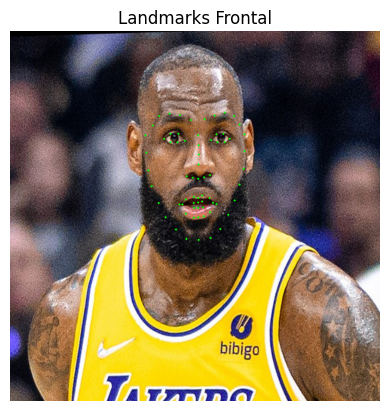

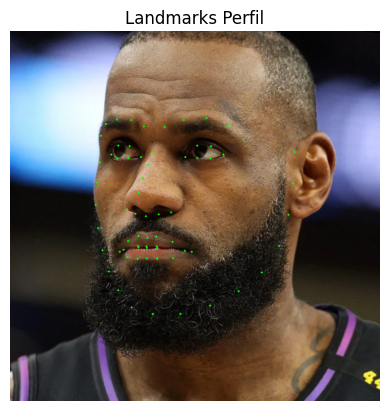

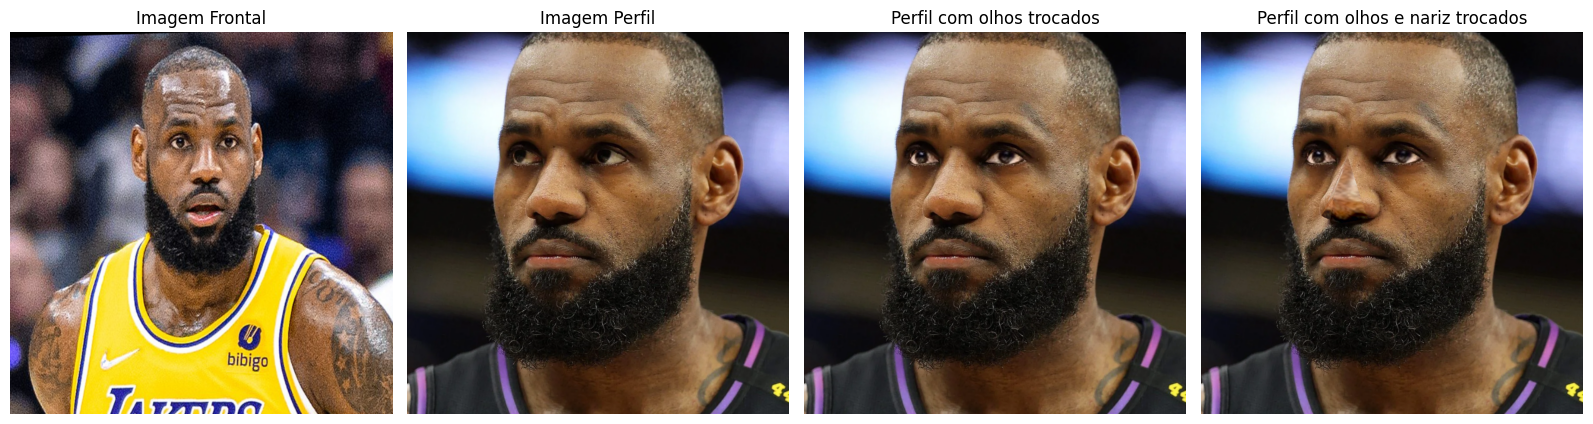

Imagens salvas com os nomes:
- perfil_olhos_trocados.jpg
- perfil_olhos_nariz.jpg


In [ ]:
#testando as funções de troca
caminho1 = "/content/drive/Shareddrives/Drive de PDI/projeto/Base/lebron_frontal.jpg"
caminho2 = "/content/drive/Shareddrives/Drive de PDI/projeto/Base/lebron_perfil.webp"

img1, lm1 = ler_imagem_e_landmarks(caminho1)
img2, lm2 = ler_imagem_e_landmarks(caminho2)

if len(lm1) != len(lm2):
    raise ValueError(f"Landmarks têm tamanhos diferentes: {len(lm1)} vs {len(lm2)}")

plot_landmarks(img1, lm1, "Landmarks Frontal")
plot_landmarks(img2, lm2, "Landmarks Perfil")

img_olhos = trocar_olhos_somente(img1, img2, lm1, lm2)

img_nariz = trocar_nariz(img1, img_olhos, lm1, lm2)

plt.figure(figsize=(20,6))
plt.subplot(1,5,1)
plt.title("Imagem Frontal")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,5,2)
plt.title("Imagem Perfil")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,5,3)
plt.title("Perfil com olhos trocados")
plt.imshow(cv2.cvtColor(img_olhos, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,5,4)
plt.title("Perfil com olhos e nariz trocados")
plt.imshow(cv2.cvtColor(img_nariz, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite("perfil_olhos_trocados.jpg", img_olhos)
cv2.imwrite("perfil_olhos_nariz.jpg", img_nariz)

print("Imagens salvas com os nomes:")
print("- perfil_olhos_trocados.jpg")
print("- perfil_olhos_nariz.jpg")

### Comparando Similaridade entre imagens

In [ ]:
#instalando dependencias para o reconhecimento facial
!pip install insightface
!pip install onnxruntime
import insightface
from insightface.app import FaceAnalysis
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 97.1 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1057638 sha256=037cbc85c637b746de40809dacf8030ad2740182d78a3d071e779455c196ad3b
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
#inicializando o app que vai fazer o reconhecimento
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 42370.90KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
#função para extrair o vetor de embeddings de uma imagem (será usado na comparação de similaridade)
def get_embedding(image):
    faces = app.get(image)
    if len(faces) == 0:
        raise ValueError("Nenhum rosto detectado.")

    #retorna o vetor de embedding da primeira face
    return faces[0].embedding

In [ ]:
#função para calcular a similaridade de cosseno em dois vetores
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [ ]:
#função para mostrar o bounding box da face em uma imagem
def show_faces(image):
  faces = app.get(image)

  for face in faces:
      box = face.bbox.astype(int)
      cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()

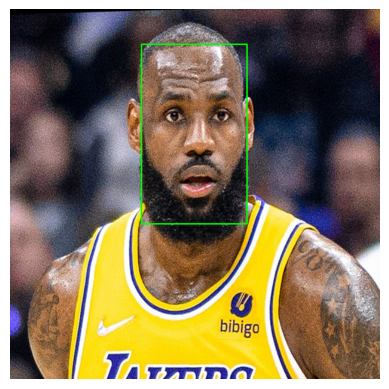

In [ ]:
show_faces(img1)

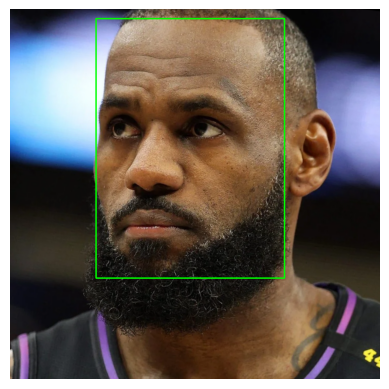

In [ ]:
show_faces(img2)

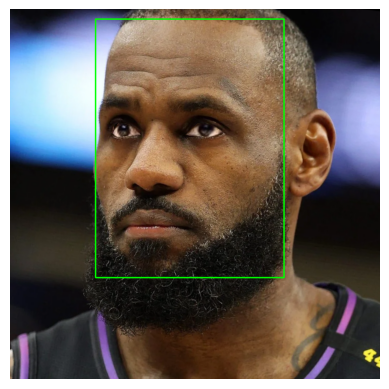

In [ ]:
show_faces(img_olhos)

In [ ]:
#resultados entre a comparação das imagens originais
emb1 = get_embedding(img1)
emb2 = get_embedding(img2)

#calculando similaridade por cosseno
similarity = cosine_similarity(emb1, emb2)

print(f"Distância entre embeddings Frontal X Perfil (Original): {similarity:.4f}")

#limiares típicos para cosseno ficam perto de 0.5 a 0.7 para mesma pessoa
if similarity > 0.5:
    print("As imagens são da mesma pessoa!")
else:
    print("As imagens são de pessoas diferentes!")

Distância entre embeddings Frontal X Perfil (Original): 0.6812
As imagens são da mesma pessoa!


In [ ]:
#resultados entre a comparação da imagem original com a alterada
emb1 = get_embedding(img1)
emb2 = get_embedding(img_olhos)

#calculando similaridade por cosseno
similarity = cosine_similarity(emb1, emb2)

print(f"Distância entre embeddings Frontal X Perfil (Morphing): {similarity:.4f}")

#limiares típicos para cosseno ficam perto de 0.5 a 0.7 para mesma pessoa
if similarity > 0.5:
    print("As imagens são da mesma pessoa!")
else:
    print("As imagens são de pessoas diferentes!")

Distância entre embeddings Frontal X Perfil (Morphing): 0.6981
As imagens são da mesma pessoa!


### Testando com Dataset criado manualmente

> O Labeled Faces in the Wild (LFW) é um conjunto de dados amplamente utilizado para tarefas de reconhecimento e verificação facial, composto por mais de 13 mil imagens de rostos de figuras públicas coletadas da internet em condições não controladas. O dataset apresenta grande variabilidade em termos de pose, iluminação, expressões faciais e oclusões, o que o torna desafiador e realista para aplicações práticas.  A ideia inicial seria aplicar os métodos descritos acima para avaliar a importância de cada característica física (nariz, olhos, boca e sobrancelhas) no reconhecimento facial de indivíduos presentes nesta base, utilizando a similaridade de cosseno a partir dos embeddings gerados pela insightface como métrica de avaliação.
No entanto, durante a implementação utilizando a LFW, surgiram diversos problemas relacionados a obtenção das imagens, que diversas vezes chegavam totalmente pretas ou de baixa qualidade, sem suporte para as operações de reconhecimento. Para contornar esse obstáculo, montou-se uma base contendo pares de imagens de 60 celebridades, respeitando a regra de uma imagem frontal e outra de perfil. Com isso, foi permitido englobar o necessário de características em diferentes para validação do projeto.

In [ ]:
import re
from collections import defaultdict
#função para agrupar os individuos da base por nome, retorna uma lista de dicionários
def agrupar_por_nome(lista_arquivos, path):
  pessoas = defaultdict(dict)

  for arquivo in lista_arquivos:
    #extrai o nome base e o tipo (frontal ou perfil)
    match = re.match(r'(.+?)_(frontal|perfil)', arquivo, re.IGNORECASE)
    if match:
        nome, tipo = match.groups()
        pessoas[nome][tipo.capitalize()] = arquivo

  #converte para lista de dicionários
  resultado = []
  for nome, imagens in pessoas.items():
    path_frontal = path + imagens.get("Frontal", nome+'_frontal.jpg')
    path_perfil = path + imagens.get("Perfil", None)
    resultado.append({
        "Nome": nome,
        "Frontal": path_frontal,
        "Perfil": path_perfil
    })

  return resultado

In [ ]:
import traceback
#essa classe engloba todas as funções anteriores para aplicar na base de dados criada
class ImageAnalyzer():
  def __init__(self, pessoas_selecionadas):
      self.pessoas_selecionadas = pessoas_selecionadas
      self.app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
      self.app.prepare(ctx_id=0)
      urllib.request.urlretrieve("https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat", './shape_predictor_68_face_landmarks.dat')
      self.frontalface_detector = dlib.get_frontal_face_detector()
      self.landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')


  def ler_imagem_e_landmarks(self, caminho):
    img, lm = self.get_landmarks(str(caminho))
    rosto, lm_alinhadas = self.alinhar_e_cortar_rosto(img, lm)
    return rosto, lm_alinhadas


  def get_landmarks(self, image_source):
    image = cv2.imread(image_source)
    if image is None:
        raise ValueError("Imagem não pôde ser carregada. Verifique a URL ou o caminho do arquivo.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = frontalface_detector(gray, 1)

    if len(faces) == 0:
        raise ValueError("Nenhum rosto detectado na imagem.")

    landmarks = [(p.x, p.y) for p in landmark_predictor(gray, faces[0]).parts()]
    return image, landmarks


  def alinhar_e_cortar_rosto(self, image, landmarks, tamanho_crop=(750,750), margem=230):

    h, w = image.shape[:2]

    olho_esq = np.mean(landmarks[36:42], axis=0)
    olho_dir = np.mean(landmarks[42:48], axis=0)

    dx = olho_dir[0] - olho_esq[0]
    dy = olho_dir[1] - olho_esq[1]
    angulo = np.degrees(np.arctan2(dy, dx))

    cx, cy = (olho_esq[0] + olho_dir[0]) / 2, (olho_esq[1] + olho_dir[1]) / 2

    M = cv2.getRotationMatrix2D((cx, cy), angulo, 1.0)
    img_rotacionada = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    landmarks_rotacionadas = []
    for (x, y) in landmarks:
        vetor = np.array([x, y, 1])
        x_rot, y_rot = M.dot(vetor)
        landmarks_rotacionadas.append((int(x_rot), int(y_rot)))

    xs = [p[0] for p in landmarks_rotacionadas]
    ys = [p[1] for p in landmarks_rotacionadas]

    min_x = max(min(xs) - margem, 0)
    max_x = min(max(xs) + margem, w)
    min_y = max(min(ys) - margem, 0)
    max_y = min(max(ys) + margem, h)

    rosto_crop = img_rotacionada[int(min_y):int(max_y), int(min_x):int(max_x)]
    landmarks_crop = [(x - min_x, y - min_y) for (x, y) in landmarks_rotacionadas]
    rosto_final = cv2.resize(rosto_crop, tamanho_crop)

    escala_x = tamanho_crop[0] / (max_x - min_x)
    escala_y = tamanho_crop[1] / (max_y - min_y)
    landmarks_final = [(int(x * escala_x), int(y * escala_y)) for (x, y) in landmarks_crop]

    return rosto_final, landmarks_final


  def aplicar_warp_triangle(self, img, tri1, tri2):
    tri1 = np.array(tri1, dtype=np.float32)
    tri2 = np.array(tri2, dtype=np.float32)

    r1 = cv2.boundingRect(tri1)
    r2 = cv2.boundingRect(tri2)

    tri1_offset = [(pt[0] - r1[0], pt[1] - r1[1]) for pt in tri1]
    tri2_offset = [(pt[0] - r2[0], pt[1] - r2[1]) for pt in tri2]

    img1_rect = img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]

    M = cv2.getAffineTransform(np.float32(tri1_offset), np.float32(tri2_offset))

    warped = cv2.warpAffine(img1_rect, M, (r2[2], r2[3]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2_offset), (1.0, 1.0, 1.0), 16, 0)

    return warped, mask, r2


  def trocar_parte(self, img_frontal, img_perfil, lm_frontal, lm_perfil, indices_parte, cor=False):
    lm_frontal_parte = [lm_frontal[i] for i in indices_parte]
    lm_perfil_parte = [lm_perfil[i] for i in indices_parte]

    tri = Delaunay(np.array(lm_frontal_parte, dtype=np.float32))
    img_saida = img_perfil.astype(np.float32).copy()

    hull_perfil = cv2.convexHull(np.array(lm_perfil_parte, dtype=np.int32))
    mask_parte = np.zeros(img_perfil.shape[:2], dtype=np.uint8)

    cv2.fillConvexPoly(mask_parte, hull_perfil, 255)

    for t in tri.simplices:
        tri_frontal = [lm_frontal_parte[t[0]], lm_frontal_parte[t[1]], lm_frontal_parte[t[2]]]
        tri_perfil = [lm_perfil_parte[t[0]], lm_perfil_parte[t[1]], lm_perfil_parte[t[2]]]

        warped, mask, r = self.aplicar_warp_triangle(img_frontal, tri_frontal, tri_perfil)

        mask_tri = mask[:, :, 0]
        mask_parte_rect = mask_parte[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
        mask_final = (mask_tri > 0).astype(np.uint8) * (mask_parte_rect > 0)

        mask_final_3c = np.repeat(mask_final[:, :, np.newaxis], 3, axis=2)

        img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] *= (1 - mask_final_3c)
        if cor:
          regiao_base = img_perfil[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
          parte_corrigida = self.ajustar_cor(warped, mask_tri, regiao_base)

          img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += parte_corrigida * mask_final_3c
        else:
          img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += warped * mask_final_3c

    return img_saida


  def trocar_olhos_somente(self, img_frontal, img_perfil, lm_frontal, lm_perfil):
    olho_direito = list(range(36, 42))
    olho_esquerdo = list(range(42, 48))

    img_intermediaria = self.trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, olho_direito)
    img_saida = self.trocar_parte(img_frontal, img_intermediaria, lm_frontal, lm_perfil, olho_esquerdo)

    return np.clip(img_saida, 0, 255).astype(np.uint8)


  def trocar_nariz(self, img_frontal, img_perfil, lm_frontal, lm_perfil):
    nariz = list(range(27, 36))
    return np.clip(self.trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, nariz, True), 0, 255).astype(np.uint8)


  def trocar_boca(self, img_frontal, img_perfil, lm_frontal, lm_perfil):
    boca = list(range(48, 60))
    return np.clip(self.trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, boca, True), 0, 255).astype(np.uint8)


  def trocar_sobrancelha(self, img_frontal, img_perfil, lm_frontal, lm_perfil):
      sobrancelha_direita = list(range(17, 22))
      img_intermediaria = self.trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, sobrancelha_direita, True)

      sobrancelha_esquerda = list(range(22, 27))
      img_saida = self.trocar_parte(img_frontal, img_intermediaria, lm_frontal, lm_perfil, sobrancelha_esquerda)

      return np.clip(img_saida, 0, 255).astype(np.uint8)


  def get_embedding(self, image):
    faces = self.app.get(image)
    if len(faces) == 0:
      return None

    # Retorna o vetor de embedding da primeira face
    return faces[0].embedding


  def cosine_similarity(self, vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

  def compare_images(self, img1, img2):
    emb1 = self.get_embedding(img1)
    emb2 = self.get_embedding(img2)

    if emb1 is None or emb2 is None:
        return None

    similarity = self.cosine_similarity(emb1, emb2)

    return similarity


  def ajustar_cor(self, parte, mask, regiao_base):
    kernel = np.ones((15, 15), np.uint8)
    dilatada = cv2.dilate(mask, kernel, iterations=1)
    entorno = dilatada - mask

    img_base = regiao_base.copy()
    mask_entorno = entorno.astype(bool)

    if not np.any(mask_entorno):
        return parte

    lab_parte = cv2.cvtColor(parte, cv2.COLOR_BGR2LAB)
    lab_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2LAB)

    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    if len(entorno.shape) == 3:
        entorno = entorno[:, :, 0]
    if entorno.dtype != np.uint8:
        entorno = entorno.astype(np.uint8)

    mean_parte, std_parte = cv2.meanStdDev(lab_parte, mask)

    mean_entorno, std_entorno = cv2.meanStdDev(lab_base, entorno)

    std_parte = np.maximum(std_parte, 1.0)

    lab_ajustada = lab_parte.astype(np.float32)

    for i in range(3):
        canal = lab_ajustada[:, :, i]
        canal[mask > 0] = ((canal[mask > 0] - mean_parte[i][0]) *
                           (std_entorno[i][0] / std_parte[i][0]) +
                           mean_entorno[i][0])
        lab_ajustada[:, :, i] = canal

    lab_ajustada = np.clip(lab_ajustada, 0, 255).astype(np.uint8)
    return cv2.cvtColor(lab_ajustada, cv2.COLOR_LAB2BGR)


  #nessa função vamos percorrer a lista de pessoas na base, extrair os landmarks, fazer o face morphing e realizar as comparações
  def run(self):
    lista_resultados = []
    for pessoa in self.pessoas_selecionadas: #lista de pessoas da base
      try:
        dict_resultado = {}
        frontal_source = pessoa.get("Frontal") #selecionando imagem frontal e de perfil
        perfil_source = pessoa.get("Perfil")

        if frontal_source is None or perfil_source is None:
            continue #se alguma das imagens for nula, pula pra poxima pessoa

        frontal_image, lm_frontal = self.ler_imagem_e_landmarks(frontal_source) #extrai os landmarks das duas imagens
        perfil_image, lm_perfil = self.ler_imagem_e_landmarks(perfil_source)

        #realiza as trocas das regiões nas imagens
        img_olhos = self.trocar_olhos_somente(frontal_image, perfil_image, lm_frontal, lm_perfil)
        img_nariz = self.trocar_nariz(frontal_image, perfil_image, lm_frontal, lm_perfil)
        img_sobrancelha = self.trocar_sobrancelha(frontal_image, perfil_image, lm_frontal, lm_perfil)
        img_olho_nariz = self.trocar_nariz(frontal_image, img_olhos, lm_frontal, lm_perfil)
        img_nariz_sobrancelha = self.trocar_sobrancelha(frontal_image, img_nariz,  lm_frontal, lm_perfil)
        img_olhos_sobrancelha = self.trocar_sobrancelha(frontal_image, img_olhos,  lm_frontal, lm_perfil)
        img_olhos_nariz_sobrancelha = self.trocar_sobrancelha(frontal_image, img_olho_nariz, lm_frontal, lm_perfil)

        #gera os resultados de comparação por similaridade de cosseno nas imagens
        dict_resultado['Frontal x Perfil'] = self.compare_images(frontal_image, perfil_image)
        dict_resultado['Frontal x Olhos'] = self.compare_images(frontal_image, img_olhos)
        dict_resultado['Frontal x Nariz'] = self.compare_images(frontal_image, img_nariz)
        dict_resultado['Frontal x Sobrancelha'] = self.compare_images(frontal_image, img_sobrancelha)
        dict_resultado['Frontal x Olhos + Nariz'] = self.compare_images(frontal_image, img_olho_nariz)
        dict_resultado['Frontal x Nariz + Sobrancelha'] = self.compare_images(frontal_image, img_nariz_sobrancelha)
        dict_resultado['Frontal x Olhos + Sobrancelha'] = self.compare_images(frontal_image, img_olhos_sobrancelha)
        dict_resultado['Frontal x Olhos + Nariz + Sobrancelha'] = self.compare_images(frontal_image, img_olhos_nariz_sobrancelha)

        #salvando os resultados no drive
        path = "/content/drive/Shareddrives/Drive de PDI/projeto/Resultados/"
        cv2.imwrite(f"{path}{pessoa['Nome']}_olhos.jpg", img_olhos)
        cv2.imwrite(f"{path}{pessoa['Nome']}_nariz.jpg", img_nariz)
        cv2.imwrite(f"{path}{pessoa['Nome']}_sobrancelha.jpg", img_sobrancelha)
        cv2.imwrite(f"{path}{pessoa['Nome']}_olho_nariz.jpg", img_olho_nariz)
        cv2.imwrite(f"{path}{pessoa['Nome']}_nariz_sobrancelha.jpg", img_nariz_sobrancelha)
        cv2.imwrite(f"{path}{pessoa['Nome']}_olhos_sobrancelha.jpg", img_olhos_sobrancelha)
        cv2.imwrite(f"{path}{pessoa['Nome']}_olhos_nariz_sobrancelha.jpg", img_olhos_nariz_sobrancelha)


        lista_resultados.append(dict_resultado)

      except Exception as e:
        print(f"Erro ao processar imagem: {e}")
        traceback.print_exc()
        continue

    return lista_resultados


In [ ]:
import os
path = "/content/drive/Shareddrives/Drive de PDI/projeto/Base/"
lista_imagens = os.listdir(path)
dict_imagens = agrupar_por_nome(lista_imagens, path)

lebron
{'Frontal': 'lebron_frontal.jpg', 'Perfil': 'lebron_perfil.webp'}
cr7
{'Frontal': 'cr7_frontal.jpg', 'Perfil': 'cr7_perfil.jpg'}
angelina
{'Frontal': 'angelina_frontal.jpg', 'Perfil': 'angelina_perfil.jpg'}
juliana
{'Perfil': 'juliana_perfil.jpg', 'Frontal': 'juliana_frontal.webp'}
murilo
{'Perfil': 'murilo_perfil.webp', 'Frontal': 'murilo_frontal.webp'}
brad
{'Frontal': 'brad_frontal.jpg', 'Perfil': 'brad_perfil.jpg'}
lady_gaga
{'Frontal': 'lady_gaga_frontal.jpg', 'Perfil': 'lady_gaga_perfil.jpg'}
tom
{'Perfil': 'tom_perfil.jpg', 'Frontal': 'tom_frontal.webp'}
deborah
{'Perfil': 'deborah_perfil.jpg', 'Frontal': 'deborah_frontal.jpg'}
scarlett
{'Frontal': 'scarlett_frontal.jpg', 'Perfil': 'scarlett_perfil.webp'}
selena_gomez
{'Frontal': 'selena_gomez_frontal.webp', 'Perfil': 'selena_gomez_perfil.jpg'}
dwayne
{'Frontal': 'dwayne_frontal.jpg', 'Perfil': 'dwayne_perfil.webp'}
luan
{'Frontal': 'luan_frontal.webp', 'Perfil': 'luan_perfil.webp'}
ivete
{'Frontal': 'ivete_frontal.webp',

In [ ]:
analyzer = ImageAnalyzer(dict_imagens) #passando o dicionário de imagens para o analisador

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
resultados = analyzer.run() #realizando a análise das imagens
resultados

Erro ao processar imagem: Imagem não pôde ser carregada. Verifique a URL ou o caminho do arquivo.


Traceback (most recent call last):
  File "<ipython-input-50-dbb4e1d7fec7>", line 258, in run
    frontal_image, lm_frontal = self.ler_imagem_e_landmarks(frontal_source)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-50-dbb4e1d7fec7>", line 14, in ler_imagem_e_landmarks
    img, lm = self.get_landmarks(str(caminho))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-50-dbb4e1d7fec7>", line 22, in get_landmarks
    raise ValueError("Imagem não pôde ser carregada. Verifique a URL ou o caminho do arquivo.")
ValueError: Imagem não pôde ser carregada. Verifique a URL ou o caminho do arquivo.


[{'Frontal x Perfil': np.float32(0.7357893),
  'Frontal x Olhos': np.float32(0.7309162),
  'Frontal x Nariz': np.float32(0.727861),
  'Frontal x Sobrancelha': np.float32(0.68009806),
  'Frontal x Olhos + Nariz': np.float32(0.7158955),
  'Frontal x Nariz + Sobrancelha': np.float32(0.6704077),
  'Frontal x Olhos + Sobrancelha': np.float32(0.68806314),
  'Frontal x Olhos + Nariz + Sobrancelha': np.float32(0.67781687)},
 {'Frontal x Perfil': np.float32(0.66820323),
  'Frontal x Olhos': np.float32(0.6624434),
  'Frontal x Nariz': np.float32(0.6437232),
  'Frontal x Sobrancelha': np.float32(0.6395105),
  'Frontal x Olhos + Nariz': np.float32(0.6357178),
  'Frontal x Nariz + Sobrancelha': np.float32(0.6098765),
  'Frontal x Olhos + Sobrancelha': np.float32(0.6480489),
  'Frontal x Olhos + Nariz + Sobrancelha': np.float32(0.6194837)},
 {'Frontal x Perfil': None,
  'Frontal x Olhos': None,
  'Frontal x Nariz': None,
  'Frontal x Sobrancelha': None,
  'Frontal x Olhos + Nariz': None,
  'Frontal 

## Analisando os resultados

> Para analisar os resultados do experimento de Face Alignment, foi desenvolvida a classe ResultAnalyzer, que recebe os dados gerados pelas comparações de similaridade entre imagens frontais e manipuladas. A classe calcula estatísticas descritivas (média e desvio padrão) para cada tipo de substituição facial — como olhos, nariz, sobrancelhas e suas combinações — permitindo avaliar o impacto individual de cada região no reconhecimento facial. Além disso, ela gera um gráfico de barras com barras de erro, um ranking das regiões com maior influência negativa sobre a similaridade, e um heatmap das similaridades por amostra, facilitando a interpretação visual dos resultados. Por fim, a ferramenta também permite exportar os dados em CSV, organizando de forma clara os efeitos do morphing sobre a preservação da identidade facial.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#essa classe recebe os resultados da análise e gera uma série de gráficos e estatísticas para realizar o estudo completo
class ResultAnalyzer:


  #inicializa a análise com a lista de dicionários de resultados.
  def __init__(self, lista_resultados):
      self.raw_data = lista_resultados
      self.df = pd.DataFrame(lista_resultados)
      self.stats = None


  #função para calcular média e desvio padrão para cada tipo de comparação
  def calcular_estatisticas(self):
      self.stats = self.df.agg(['mean', 'std', 'count', 'sum']).T.rename(columns={'mean': 'Média', 'std': 'Desvio Padrão', 'count': 'Número de Registros', 'sum': 'soma'})
      self.stats = self.stats.sort_values(by='Média', ascending=False)
      return self.stats


  #função para exibir a tabela de estatísticas de forma organizada
  def exibir_tabela(self):
      if self.stats is None:
          self.calcular_estatisticas()
      display(self.stats.style.format("{:.4f}").highlight_max(color='lightgreen').highlight_min(color='salmon'))


  #plota gráfico de barras com barra de erro
  def plotar_grafico_barras(self):
      if self.stats is None:
          self.calcular_estatisticas()

      plt.figure(figsize=(12, 6))
      plt.bar(self.stats.index, self.stats['Média'], yerr=self.stats['Desvio Padrão'], capsize=5, color='skyblue')
      plt.xticks(rotation=45, ha='right')
      plt.ylabel('Similaridade Média (Cosseno)')
      plt.title('Similaridade Média por Tipo de Substituição')
      plt.grid(axis='y')
      plt.tight_layout()
      plt.show()


  #retorna ranking do impacto das substituições (menor média = maior impacto)
  def ranking_regioes(self):
      if self.stats is None:
          self.calcular_estatisticas()
      ranking = self.stats.sort_values(by='Média', ascending=True)
      return ranking


  #plota heatmap das similaridades por pessoa
  def plotar_heatmap(self):
      plt.figure(figsize=(14, len(self.df) * 0.5))
      sns.heatmap(self.df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
      plt.title("Heatmap de Similaridade (Frontal x Manipulada)")
      plt.xlabel("Tipo de Substituição")
      plt.ylabel("Amostras")
      plt.tight_layout()
      plt.show()


  #exporta os dados brutos e estatísticas para CSV.
  def exportar_csv(self, nome_arquivo='resultados_analise.csv'):
      self.df.to_csv(nome_arquivo, index=False)
      print(f"Arquivo exportado: {nome_arquivo}")

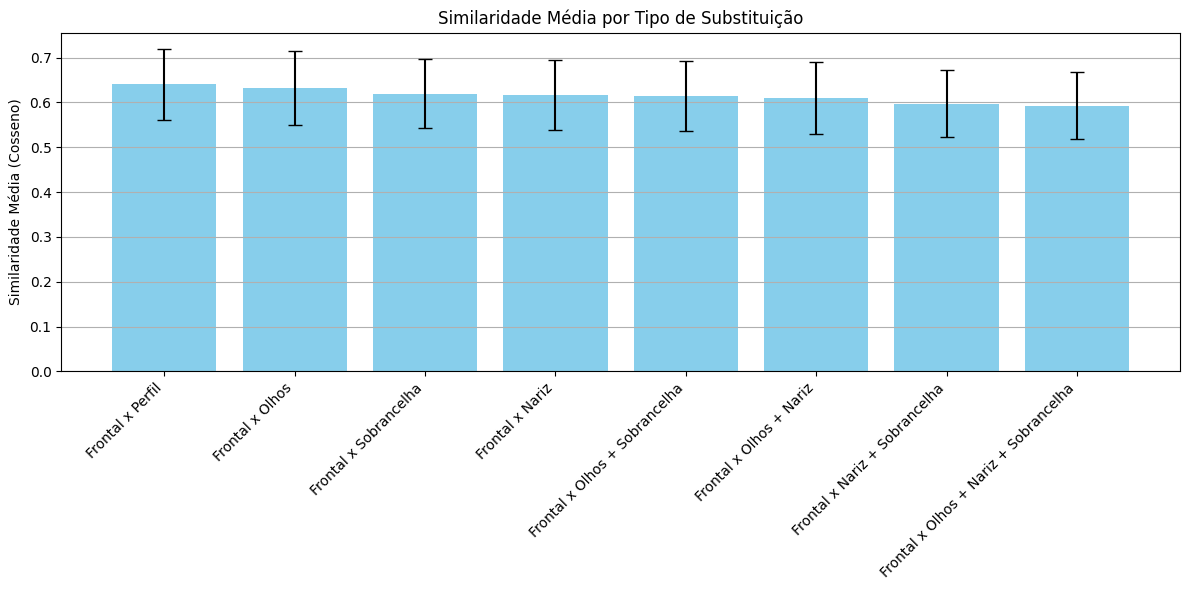

Ranking de impacto das regiões:
                                          Média  Desvio Padrão  \
Frontal x Olhos + Nariz + Sobrancelha  0.592733       0.074957   
Frontal x Nariz + Sobrancelha          0.597271       0.074969   
Frontal x Olhos + Nariz                0.609641       0.079706   
Frontal x Olhos + Sobrancelha          0.613957       0.077469   
Frontal x Nariz                        0.616454       0.077859   
Frontal x Sobrancelha                  0.619932       0.076733   
Frontal x Olhos                        0.631898       0.081821   
Frontal x Perfil                       0.640078       0.079232   

                                       Número de Registros       soma  
Frontal x Olhos + Nariz + Sobrancelha                 37.0  21.931129  
Frontal x Nariz + Sobrancelha                         37.0  22.099044  
Frontal x Olhos + Nariz                               37.0  22.556710  
Frontal x Olhos + Sobrancelha                         37.0  22.716410  
Frontal x Nar

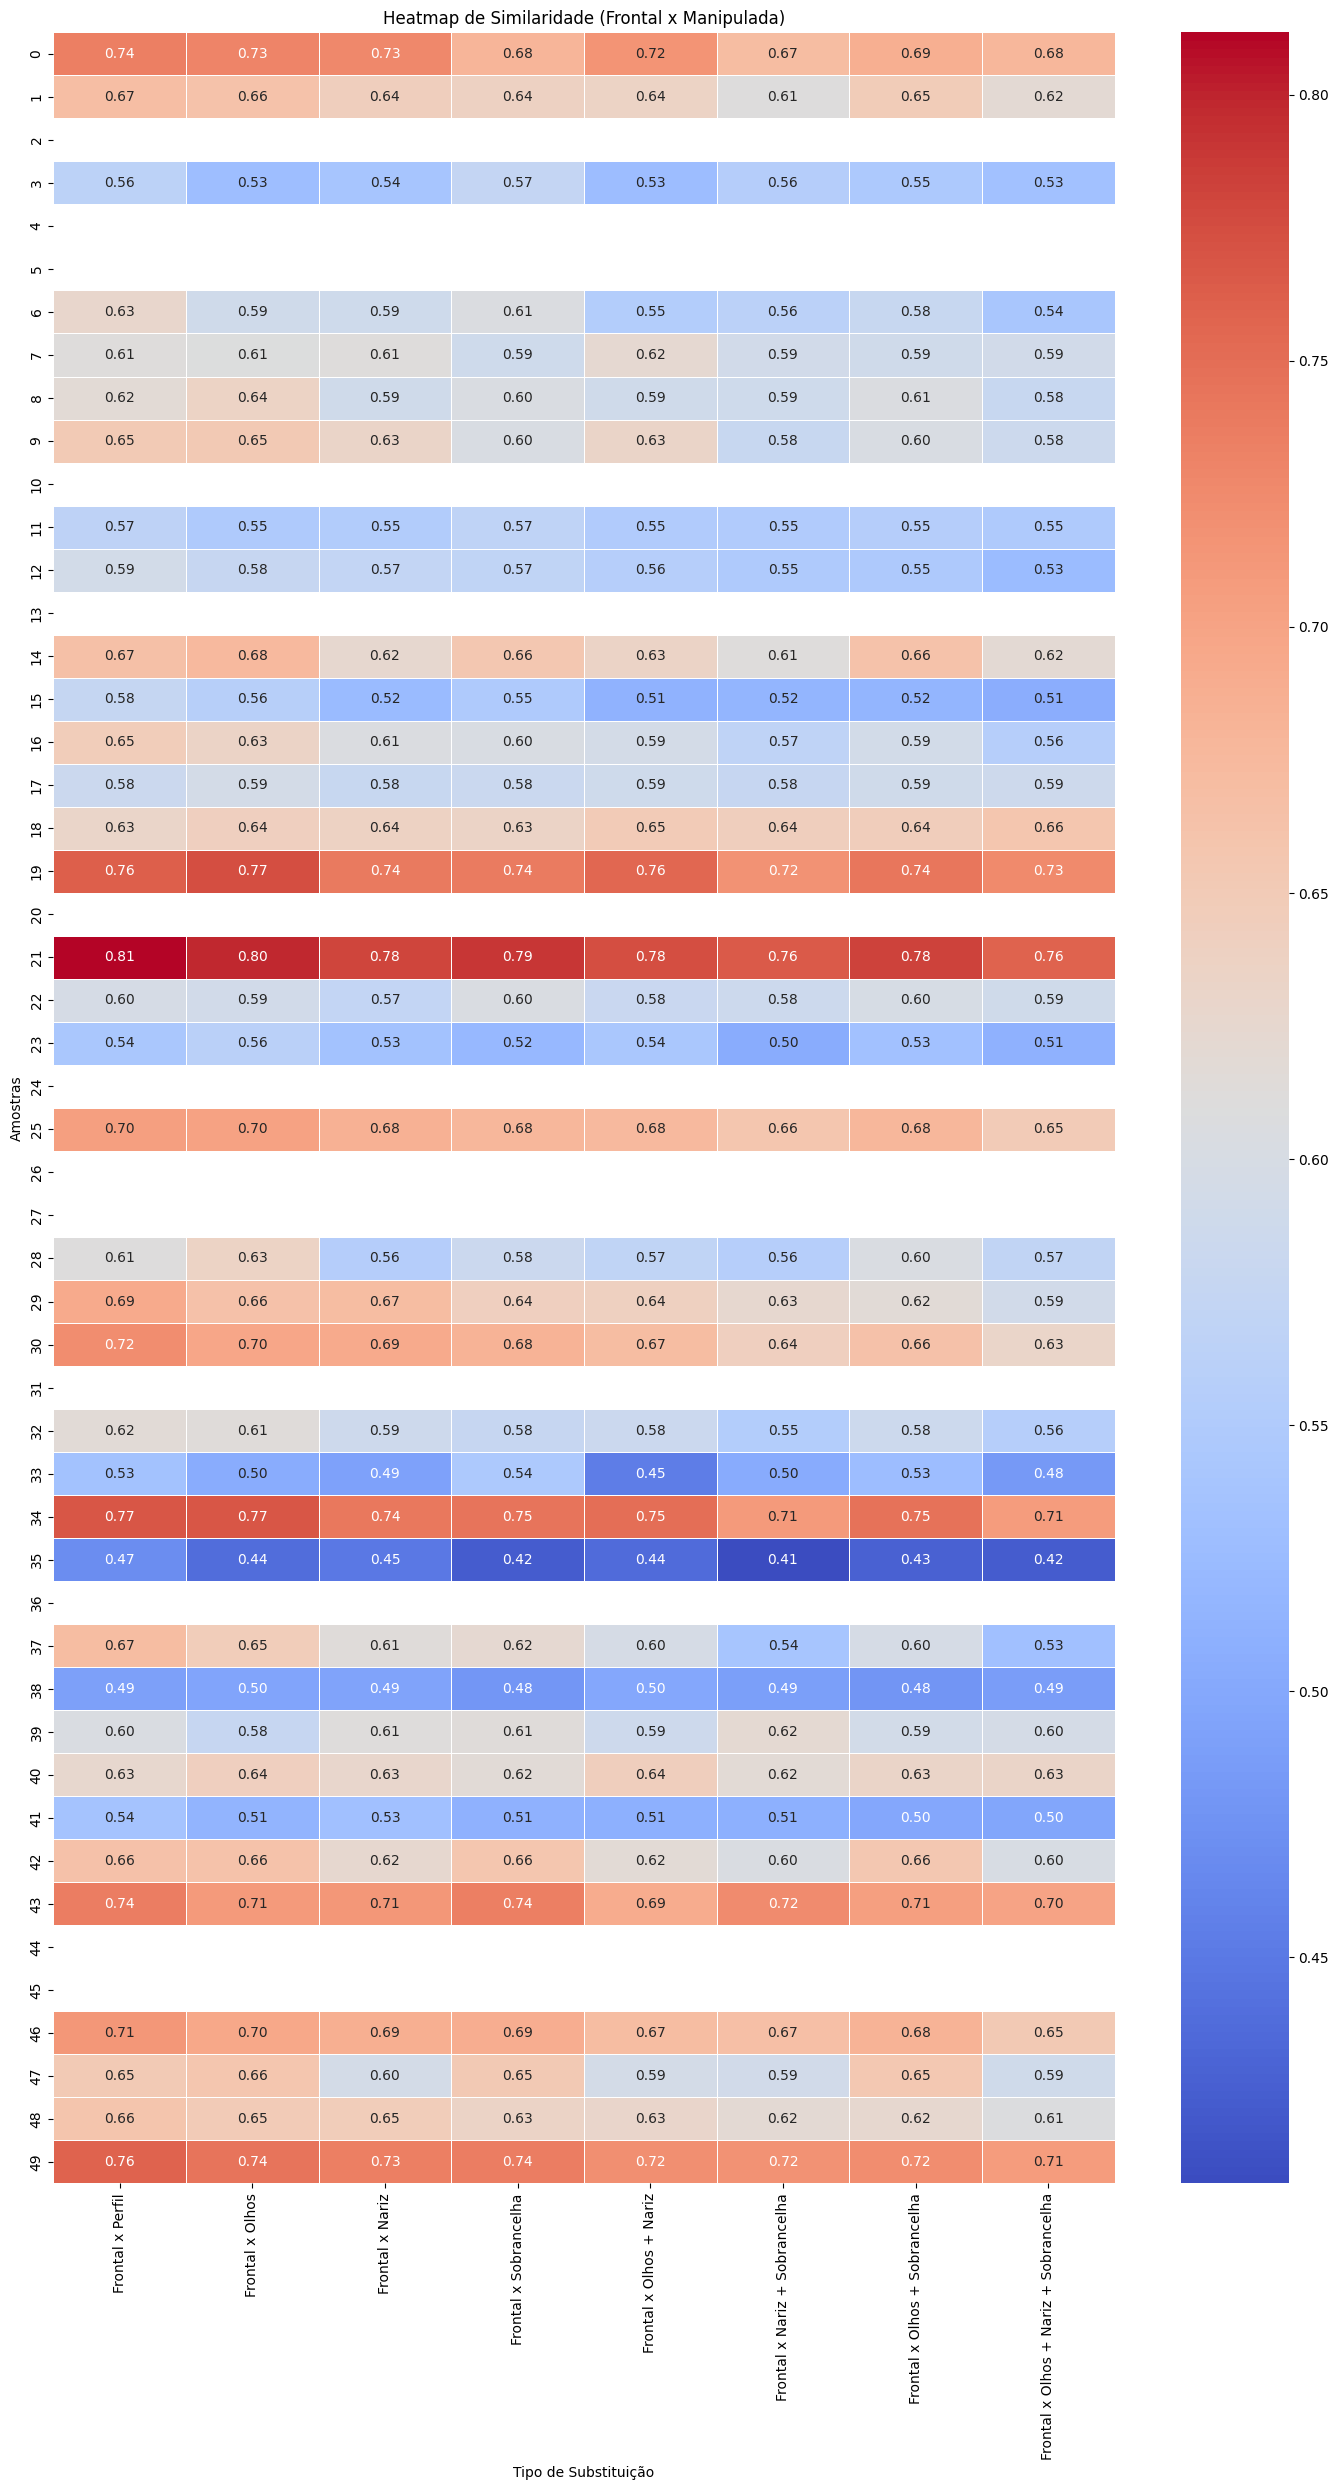

Arquivo exportado: resultados_analise.csv


In [ ]:
analisador = ResultAnalyzer(resultados) #resultados gerados anteriormente

#gerando estatísticas
estatisticas = analisador.calcular_estatisticas()
analisador.exibir_tabela()

#plotando ráfico de barras
analisador.plotar_grafico_barras()

#exibindo ranking de impacto
ranking = analisador.ranking_regioes()
print("Ranking de impacto das regiões:")
print(ranking)

#exibindo heatmap
analisador.plotar_heatmap()

#exportando os dados
analisador.exportar_csv()